# **LaTeX table with the BAO-fit results**

This notebook shows how to create a LaTeX table with the BAO-fit results varying the settings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from itertools import product
import os
from utils_baofit import BAOFitInitializer

mock_id_list = range(290)

fit_results = {}

for mock_id in mock_id_list:
    # 1. Arguments
    class Args:
        def __init__(self):
            self.include_wiggles = "y"
            self.dataset = "DESIY1_LRG_EZ"
            self.weight_type = 1 # it will not be used...
            self.mock_id = mock_id
            self.nz_flag = "mocks"
            self.cov_type = "mocks"
            self.cosmology_template = "desifid"
            self.cosmology_covariance = "desifid"
            self.delta_theta = 0.2
            self.theta_min = 0.5
            self.theta_max = 8
            self.n_broadband = 3
            self.bins_removed = []
            self.diag_only = "n"
            self.remove_crosscov = "n"
            self.alpha_min = 0.8
            self.alpha_max = 1.2
            self.base_path = None
    args = Args()
    args.include_wiggles = "" if args.include_wiggles == "y" else "_nowiggles"
    
    # 4. BAO fit initializer. This basically creates the path to save the results
    baofit_initializer = BAOFitInitializer(
        include_wiggles=args.include_wiggles,
        dataset=args.dataset,
        weight_type=args.weight_type,
        mock_id=args.mock_id,
        nz_flag=args.nz_flag,
        cov_type=args.cov_type,
        cosmology_template=args.cosmology_template,
        cosmology_covariance=args.cosmology_covariance,
        delta_theta=args.delta_theta,
        theta_min=args.theta_min,
        theta_max=args.theta_max,
        n_broadband=args.n_broadband,
        bins_removed=args.bins_removed,
        alpha_min=args.alpha_min,
        alpha_max=args.alpha_max,
        verbose=False,
        base_path=args.base_path,
    )

    fit_results[mock_id] = np.loadtxt(os.path.join(baofit_initializer.path_baofit, "fit_results.txt"))


In [3]:
import pandas as pd

data = []
for key, values in fit_results.items():
    mock_id = key
    alpha, sigma_alpha, chi2, dof = values
    data.append([mock_id, alpha, sigma_alpha, chi2, int(dof)])

df = pd.DataFrame(data, columns=["Mock id", r"$\alpha$", r"$\sigma_\alpha$", r"$\chi^2$", "dof"])

df[r"$\alpha$"] = df[r"$\alpha$"].map(lambda x: f"{x:.3f}")
df[r"$\sigma_\alpha$"] = df[r"$\sigma_\alpha$"].map(lambda x: f"{x:.3f}")
df[r"$\chi^2$"] = df[r"$\chi^2$"].map(lambda x: f"{x:.1f}")
df["dof"] = df["dof"].astype(int)

latex_table = df.to_latex(index=False, escape=False, column_format="c|cccc")

print(latex_table)


\begin{tabular}{c|cccc}
\toprule
Mock id & $\alpha$ & $\sigma_\alpha$ & $\chi^2$ & dof \\
\midrule
0 & 1.006 & 0.015 & 457.1 & 434 \\
1 & 1.024 & 0.015 & 418.5 & 434 \\
2 & 1.000 & 0.015 & 426.0 & 434 \\
3 & 0.984 & 0.012 & 435.4 & 434 \\
4 & 1.011 & 0.011 & 437.4 & 434 \\
5 & 0.993 & 0.012 & 463.5 & 434 \\
6 & 1.022 & 0.016 & 441.7 & 434 \\
7 & 0.987 & 0.013 & 453.3 & 434 \\
8 & 0.982 & 0.012 & 438.7 & 434 \\
9 & 0.997 & 0.012 & 466.1 & 434 \\
10 & 0.997 & 0.015 & 462.3 & 434 \\
11 & 0.979 & 0.013 & 446.1 & 434 \\
12 & 1.019 & 0.013 & 425.9 & 434 \\
13 & 1.009 & 0.013 & 446.1 & 434 \\
14 & 0.971 & 0.013 & 434.7 & 434 \\
15 & 1.019 & 0.014 & 466.6 & 434 \\
16 & 1.010 & 0.014 & 443.4 & 434 \\
17 & 1.010 & 0.015 & 465.0 & 434 \\
18 & 0.985 & 0.012 & 430.8 & 434 \\
19 & 1.017 & 0.012 & 443.0 & 434 \\
20 & 1.041 & 0.015 & 445.3 & 434 \\
21 & 1.004 & 0.012 & 423.8 & 434 \\
22 & 0.968 & 0.012 & 454.8 & 434 \\
23 & 0.993 & 0.013 & 464.4 & 434 \\
24 & 0.987 & 0.014 & 462.5 & 434 \\
25 & 1.015 

1.0005617241379308
0.013656551724137931
[448.46771103448276, 434.0]


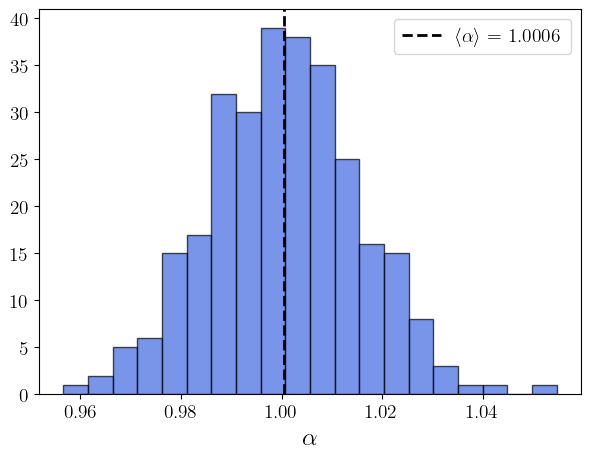

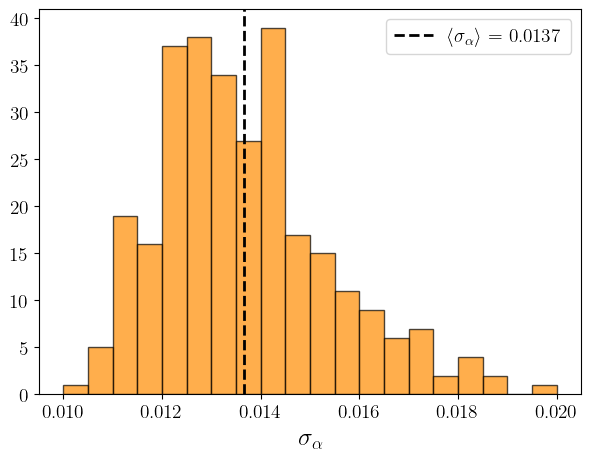

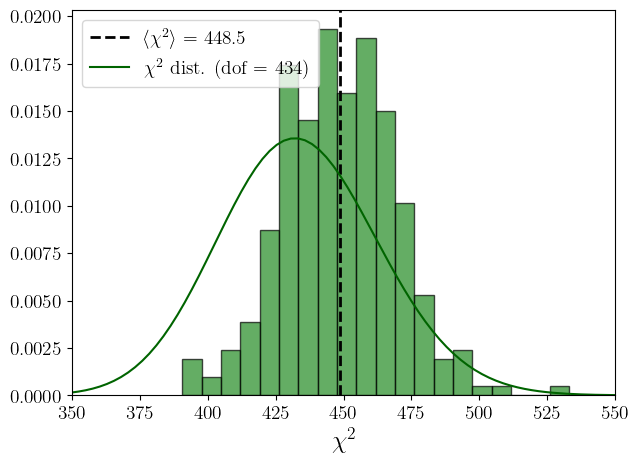

In [20]:
import matplotlib.pyplot as plt
from scipy.stats import chi2

# Define figure size
figsize = (7, 5)

# Compute means
mean_alpha = np.mean([fit_results[mock_id][0] for mock_id in mock_id_list])
mean_sigma_alpha = np.mean([fit_results[mock_id][1] for mock_id in mock_id_list])
mean_chi2 = np.mean([fit_results[mock_id][2] for mock_id in mock_id_list])

# Histogram for alpha
plt.figure(figsize=figsize)
plt.hist([fit_results[mock_id][0] for mock_id in mock_id_list], bins=20, color='royalblue', edgecolor='black', alpha=0.7)
plt.axvline(mean_alpha, color='black', linestyle="--", linewidth=2, label=fr'$\langle\alpha\rangle$ = {mean_alpha:.4f}')
plt.xlabel(r'$\alpha$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

# Histogram for sigma_alpha
plt.figure(figsize=figsize)
plt.hist([fit_results[mock_id][1] for mock_id in mock_id_list], bins=20, color='darkorange', edgecolor='black', alpha=0.7)
plt.axvline(mean_sigma_alpha, color='black', linestyle="--", linewidth=2, label=fr'$\langle\sigma_\alpha\rangle$ = {mean_sigma_alpha:.4f}')
plt.xlabel(r'$\sigma_{\alpha}$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

# Histogram for chi^2
plt.figure(figsize=figsize)
plt.hist([fit_results[mock_id][2] for mock_id in mock_id_list], bins=20, density=True, color='forestgreen', edgecolor='black', alpha=0.7)
plt.axvline(mean_chi2, color='black', linestyle="--", linewidth=2, label=fr'$\langle\chi^2\rangle$ = {mean_chi2:.1f}')
plt.xlabel(r'$\chi^2$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Overlay chi-squared distribution
dof = fit_results[0][3]
x = np.linspace(0, dof * 3, 500)
pdf = chi2.pdf(x, dof)
plt.plot(x, pdf, label=fr'$\chi^2$ dist. (dof = {int(dof)})', color='darkgreen')
plt.xlim([350, 550])
plt.legend(loc='upper left', fontsize=14)

# Print means
print(mean_alpha)
print(mean_sigma_alpha)
print([mean_chi2, dof])


In [22]:
1/np.sqrt(1/0.0243**2+1/0.0248**2+1/0.0165**2)

0.011958682390794667

In [24]:
lrg1 = 0.0243/1.0035
lrg2 = 0.0248/0.9402
lrg3 = 0.0165/1.0080

1/np.sqrt(1/lrg1**2+1/lrg2**2+1/lrg3**2)

0.01206067377595705